#### Manual Strategy Execution
I can use the LSEG refinitiv API for data collection | RUN Refinitiv Workspace in background for {Automatic Authentication}

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import refinitiv.data as rd
from refinitiv.data.content import fundamental_and_reference
import os
from pprint import pprint
import seaborn as sns
from IPython.display import display
import time
from warnings import filterwarnings
import importlib
filterwarnings('ignore') 

In [154]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [155]:
import utils
import utils.methods
import utils.retrieve
importlib.reload(utils.methods)
importlib.reload(utils.retrieve)

<module 'utils.retrieve' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Options\\Quant&Finance\\QRT_Acad\\ML_PT\\Research\\utils\\retrieve.py'>

In [156]:
from utils.methods import SelectCointegratedPairs
from utils.retrieve import _call_stocks

In [157]:
print(np.__version__)
print(rd.__version__)

tmp_fields = ["TRDPRC_1", "OPEN_PRC", "HIGH_1", "LOW_1", "ACVOL_UNS"]
start = "2024-01-01"
end = "2024-12-31"
day_limit = 252
variance_perc = 0.9
cluster_distance_threshold = None
cluster_percentile = 20

1.26.4
1.6.2


In [158]:
# api_key = os.environ("LSEG_API_KEY")
# rd.open_session(app_key=api_key)
rd.open_session()

<refinitiv.data.session.Definition object at 0x159c167d1f0 {name='workspace'}>

##### Universe Retrieval

In [159]:
stocks = _call_stocks(limit=50)
print(stocks[:10])

# stocks = universe_creation()

['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'HBAN.OQ', 'ON.OQ', 'EVRG.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ']


In [160]:
### Snapshots for Pricing
df = rd.get_data(
    universe=stocks,
    fields=tmp_fields,
    parameters={"SDate": start, "EDate": end, "Frq": "D", "Curn":"USD"}
)

display(df.head(5))
print()

,Instrument,TRDPRC_1,OPEN_PRC,HIGH_1,LOW_1,ACVOL_UNS
0,POOL.OQ,343.5,347.0,347.35,340.81,183734
1,CHRW.OQ,99.92,99.6,99.99,98.63,419598
2,FOX.OQ,52.75,52.54,52.91,51.795,722479
3,HBAN.OQ,16.89,16.77,16.925,16.66,4290980
4,ON.OQ,51.95,52.08,52.955,51.9,3376475


##### LSEG .get_history() information - A FY has 252 trading days
<br>

| Column Name  | Description  |
|-------------|--------------|
| **TRDPRC_1** | Last traded price (closing price for that period). |
| **HIGH_1** | Highest price reached during the time period. |
| **LOW_1** | Lowest price reached during the time period. |
| **ACVOL_UNS** | Accumulated volume of trades (unscaled). |
| **OPEN_PRC** | Opening price of the asset for that period. |
| **BID** | Last recorded bid price (highest price a buyer is willing to pay). |
| **ASK** | Last recorded ask price (lowest price a seller is willing to accept). |
| **TRNOVR_UNS** | Turnover (traded value) in unscaled units. |
| **VWAP** | **Volume Weighted Average Price** - average trading price considering volume. |
| **BLKCOUNT** | Number of block trades (large transactions executed outside regular markets). |
| **BLKVOLUM** | Volume of shares traded in block trades. |
| **NUM_MOVES** | Number of price movements during the period. |
| **TRD_STATUS** | Trading status (e.g., open, closed, halted, auction, etc.). |
| **SALTIM** | Time of the last trade in seconds from midnight. |
| **CLS_AUCVOL** | Volume traded during the **closing auction**. |
| **OPN_AUCVOL** | Volume traded during the **opening auction**. |
| **VWAP_VOL** | Volume used to calculate VWAP (if different from ACVOL_UNS). |


In [161]:
ft = time.time()
df_uni10 = rd.get_history(universe=stocks, fields=tmp_fields, interval="1D", start = start, end = end).dropna()
lt = time.time()

print('retrieval-time: ', (lt - ft) / 60, 'mins')

display(df_uni10.head(5))

print(df_uni10.shape)

# for nm in universe_creation():
#     print('NAME:', nm)
#     display(df_uni10[nm].head(2))

retrieval-time:  0.10099282264709472 mins


POOL.OQ                                      CHRW.OQ           \
           TRDPRC_1 OPEN_PRC  HIGH_1    LOW_1 ACVOL_UNS TRDPRC_1 OPEN_PRC   
Date                                                                        
2024-01-02   388.15   394.26  397.91  385.875    133606    87.13    86.43   
2024-01-03   373.78   382.87  383.02   373.43    120446    87.34     87.0   
2024-01-04   372.87   370.33  376.59   370.33    120317    88.21     87.0   
2024-01-05   377.73    371.6   379.5    371.6    116879    88.59    87.85   
2024-01-08   381.44   374.63  382.21   374.63     92281    87.59    88.37   

                                      ...  VRSN.OQ                            \
            HIGH_1   LOW_1 ACVOL_UNS  ... TRDPRC_1 OPEN_PRC   HIGH_1   LOW_1   
Date                                  ...                                      
2024-01-02  87.545   86.33    533940  ...   201.56    204.0   205.09  200.47   
2024-01-03   89.58   86.71    956526  ...   201.21   200.65   201.94  198.84   
2024-01-04   88.43   86.93    557729  ...   198.48   201.31   201.35   198.3   
2024-01-05    89.7   87.84    770055  ...   196.91   198.48  200.015  196.47   
2024-01-08   88.37  86.625    498999  ...    199.0   197.66   199.06  196.72   

                      TECH.OQ                                   
           ACVOL_UNS TRDPRC_1 OPEN_PRC HIGH_1  LOW_1 ACVOL_UNS  
Date                                                            
2024-01-02    250559    76.71    76.38  77.87  75.84    383635  
2024-01-03    285964    72.14    76.48  76.51  71.85    464119  
2024-01-04    209511    72.42    72.14  72.45  71.72    607913  
2024-01-05    247722    71.09    71.96  72.77  71.05    386416  
2024-01-08    203646    72.91    71.19  73.24  70.49    329670  

[5 rows x 90 columns]

(252, 90)


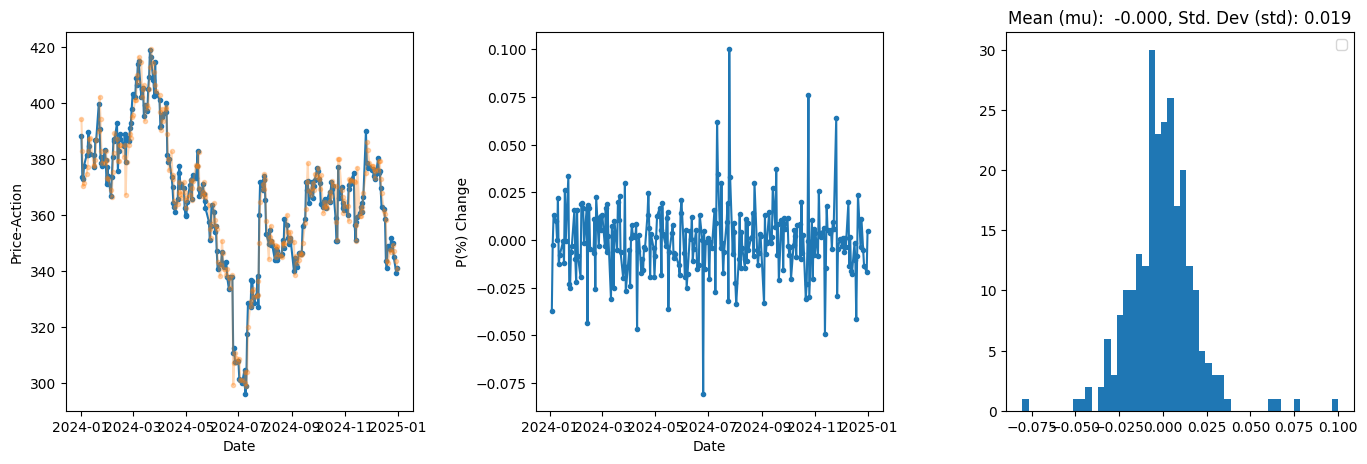

In [162]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

### We just do multi-indexing
axs[0].plot(df_uni10.index, df_uni10[stocks[0]]['TRDPRC_1'], marker = '.', label='close')
axs[0].plot(df_uni10.index, df_uni10[stocks[0]]['OPEN_PRC'], marker = '.', label='open', alpha=0.3)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price-Action')

axs[1].plot(df_uni10.index, df_uni10[stocks[0]]['TRDPRC_1'].pct_change(), marker = '.', label='close')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('P(%) Change')

axs[2].hist(df_uni10[stocks[0]]['TRDPRC_1'].pct_change(), bins = 50)
_mu = df_uni10[stocks[0]]['TRDPRC_1'].pct_change().mean()
_std = df_uni10[stocks[0]]['TRDPRC_1'].pct_change().std()
axs[2].set_title(f'Mean (mu):  {_mu:.3f}, Std. Dev (std): {_std:.3f}')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [ ]:
print('LEN: ', len(stocks))

LEN:  19


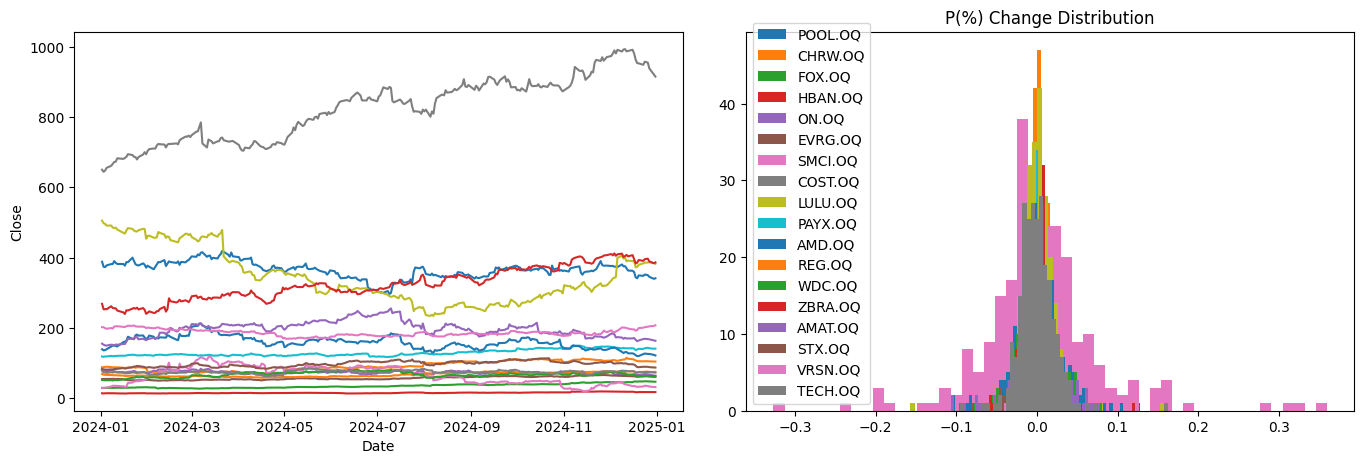

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

### We just do multi-indexing
for nm in stocks:
    axs[0].plot(df_uni10.index, df_uni10[nm]['TRDPRC_1'], label = nm)
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel('Close')

plt.legend()

for nm in stocks:

    pct_change_clean = df_uni10[nm]['TRDPRC_1'].pct_change().dropna()

    if pct_change_clean.empty:
        print(f"Skipping {nm} due to no valid percentage change data.")
        continue
    
    axs[1].hist(pct_change_clean, bins = 50, label = nm)
    axs[1].set_title(f'P(%) Change Distribution')

plt.tight_layout(pad = 2)
plt.legend()
plt.show()

In [167]:
fundamental_df = rd.get_data(
    universe=stocks,
    fields=["TR.Revenue.date", "TR.Revenue", "TR.GrossProfit", "TR.MktCap", "TR.BasicWeightedAvgShares"],
    parameters={
        "SDate": start,
        "EDate": end, # Full fiscal year
        "FRQ": "D", # Fiscal Year frequency (more standard than "A")
        "Curn": "USD" # Currency normalization
    }
)

display(fundamental_df.head(5))
print(fundamental_df.shape)
print(fundamental_df.columns)

## creates multi-index based on column indexing
fundamental_df = fundamental_df.set_index(['Instrument', 'Date'])

display(fundamental_df.head(5))
print(fundamental_df.shape)

display(fundamental_df.loc[stocks[0]].head(5))

RDError: Error code -1 | UDF Core request failed. Gateway Time-out Requested universes: ['POOL.OQ', 'CHRW.OQ', 'FOX.OQ', 'HBAN.OQ', 'ON.OQ', 'EVRG.OQ', 'SMCI.OQ', 'COST.OQ', 'LULU.OQ', 'PAYX.OQ', 'AMD.OQ', 'REG.OQ', 'WDC.OQ', 'ZBRA.OQ', 'AMAT.OQ', 'STX.OQ', 'VRSN.OQ', 'TECH.OQ']. Requested fields: ['TR.REVENUE.DATE', 'TR.REVENUE', 'TR.GROSSPROFIT', 'TR.MKTCAP', 'TR.BASICWEIGHTEDAVGSHARES']

['2023-09-30T00:00:00.000000000' '2024-09-28T00:00:00.000000000']


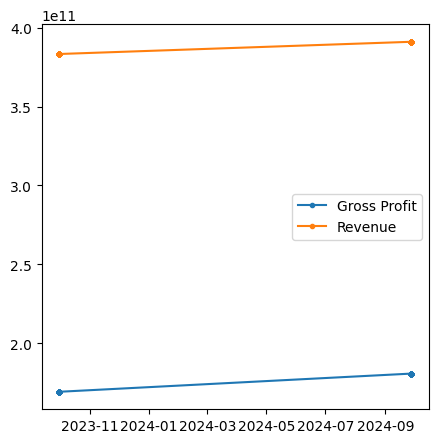

In [ ]:
fig = plt.figure(figsize=(5, 5))

print(np.unique(np.array(fundamental_df.loc[stocks[0]].index))) ### Maybe thats the time when gross-profit and revenue gets published (but shouldn't that be q1-4) - annual report for 1FY not quartly 
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Gross Profit'], marker = '.', label = 'Gross Profit')
plt.plot(fundamental_df.loc[stocks[0]].index, fundamental_df.loc[stocks[0]]['Revenue'], marker = '.', label = 'Revenue')

plt.legend()
plt.show()

In [ ]:
rd.close_session()

In [ ]:
val_dict = {}
val_arr = []

for nm in stocks:
    pct = np.array(df_uni10[nm]['TRDPRC_1'].pct_change().fillna(0)).tolist()
    close = np.array(df_uni10[nm]['TRDPRC_1']).tolist()
    vol = np.array(df_uni10[nm]['ACVOL_UNS']).tolist()
    revenue = np.array(fundamental_df.loc[nm]['Revenue']) 
    gross_profit = np.array(fundamental_df.loc[nm]['Gross Profit'])
    was = np.array(fundamental_df.loc[nm]['Basic Weighted Average Shares'])

    val_arr.append([close, pct, vol, revenue, gross_profit, was])
    val_dict[nm] = [close, pct, vol, revenue, gross_profit, was]

val_arr = np.array(val_arr).reshape(len(stocks), -1)
print(val_arr.shape)

(19, 1512)


##### PCA + Clustering
A fixed n_components shows systemic risk/volatility which shows fewer components moving the market while unsystemic risk shows diversification and more singular stock trading oppurtunity  

(19, 6)


<Figure size 500x500 with 0 Axes>

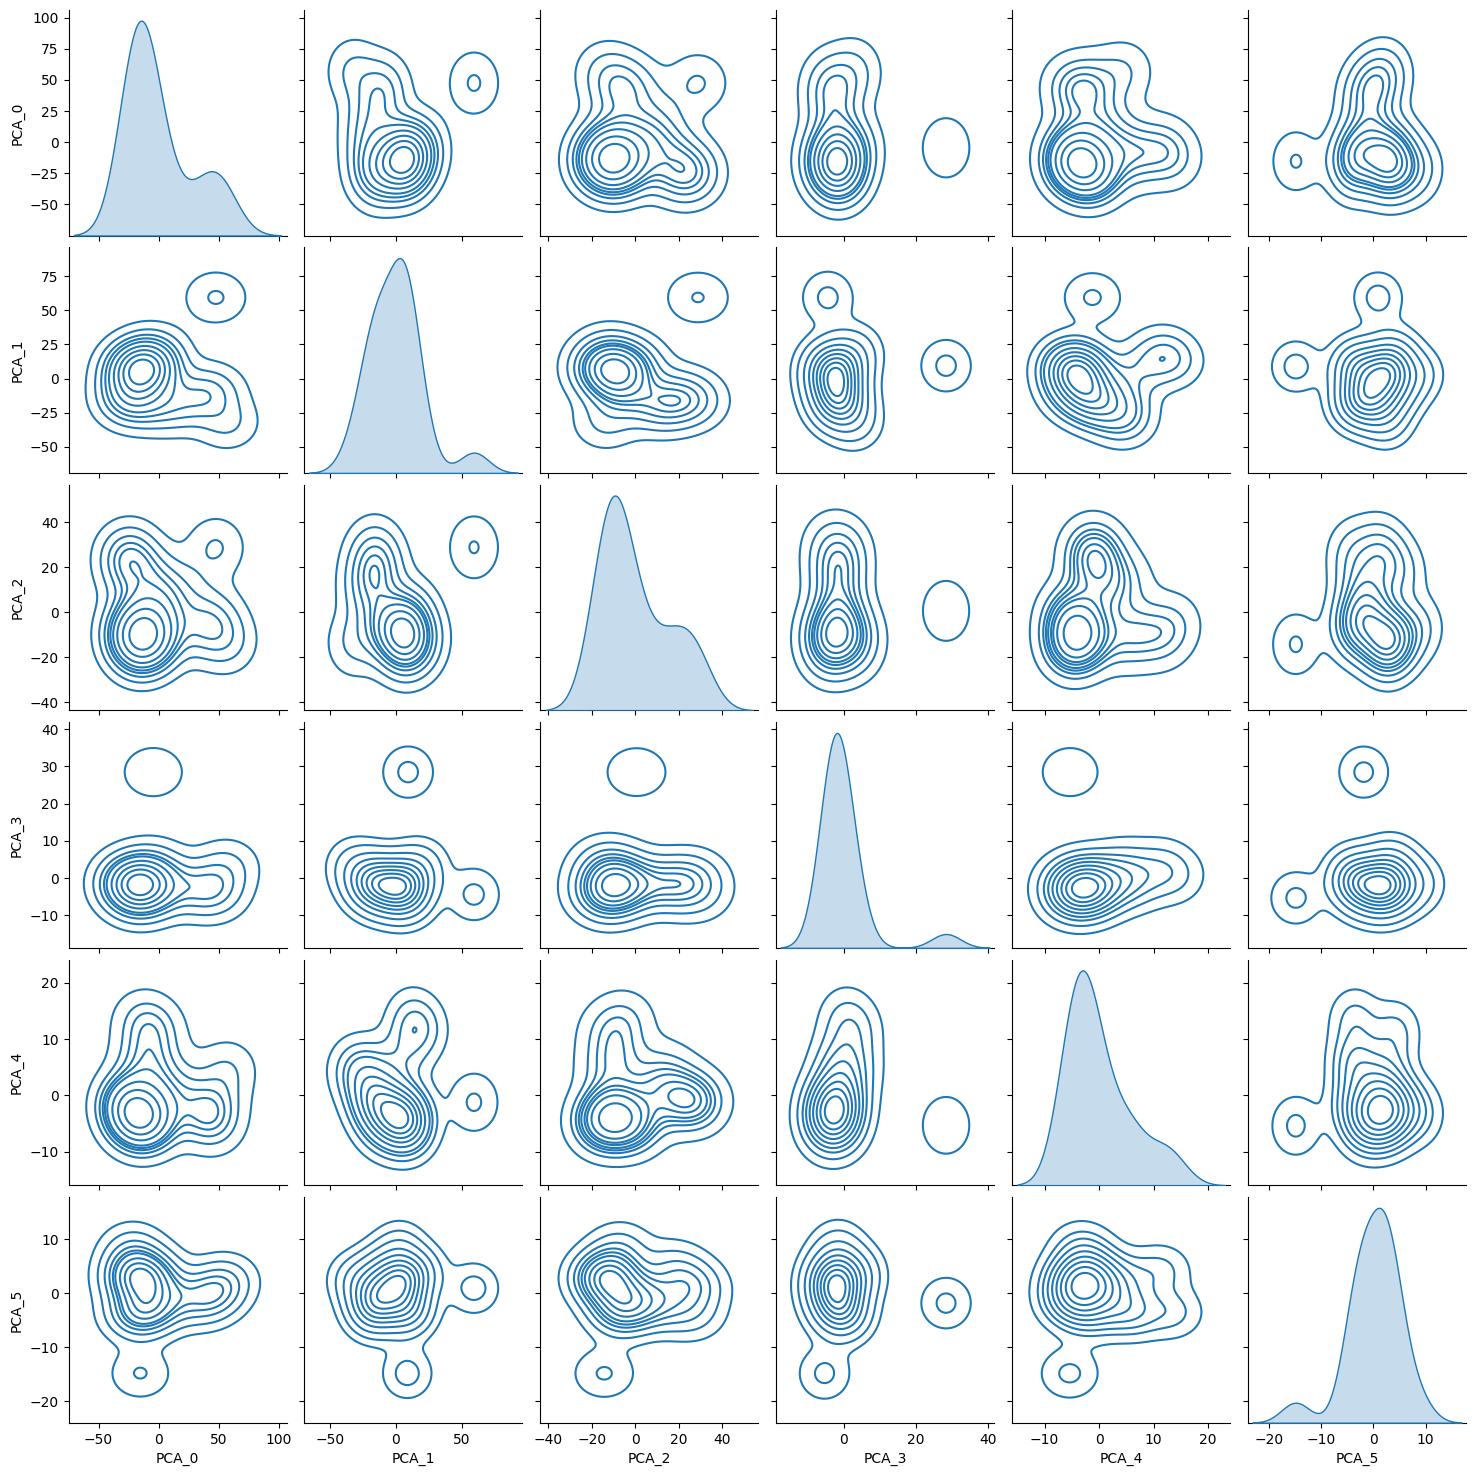

In [ ]:
scaler = StandardScaler()
scaled_arr = scaler.fit_transform(val_arr)

pca = PCA(n_components=variance_perc)
pca_arr = pca.fit_transform(scaled_arr)

print(pca_arr.shape)

fig = plt.figure(figsize=(5, 5))

sns.pairplot(pd.DataFrame(pca_arr, columns=['PCA_' + str(i) for i in range(pca_arr.shape[-1])]), kind='kde')
plt.show()

In [ ]:
pairwise_distances = np.linalg.norm(pca_arr[:, np.newaxis] - pca_arr, axis=2)
upper_tri_indices = np.triu_indices_from(pairwise_distances, k=1)
distances = pairwise_distances[upper_tri_indices]

min_distance = distances.min()
max_distance = distances.max()

if min_distance < 0:
    min_distance = 0.0
if max_distance < 0:
    max_distance = 1.0

### closest 20% points used for agglo cluster formation
cluster_distance_threshold = np.percentile(distances, cluster_percentile)

# Validate cluster_distance_threshold
if not np.isfinite(cluster_distance_threshold) or cluster_distance_threshold < 0:
    cluster_distance_threshold = 1.0  # Default positive value        

In [ ]:
aggl_cluster = AgglomerativeClustering(
        linkage='average',
        n_clusters=None,
        distance_threshold=cluster_distance_threshold
)

cluster_labels = aggl_cluster.fit_predict(pca_arr)
print('Number of Clusters: ', len(np.unique(cluster_labels)))

Number of Clusters:  8


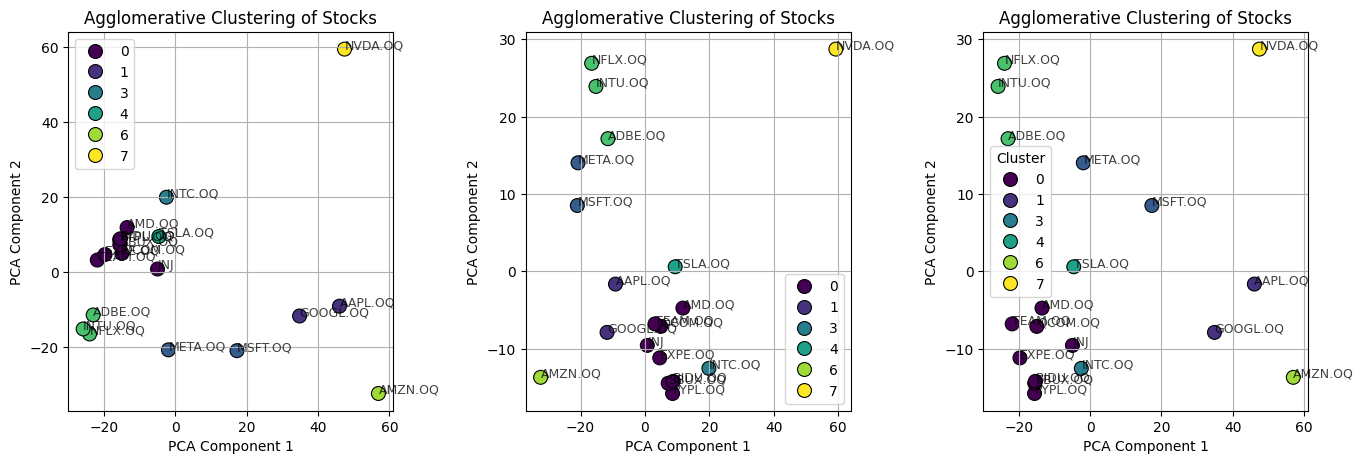

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 1], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[0])
sns.scatterplot(x=pca_arr[:, 1], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[1])
sns.scatterplot(x=pca_arr[:, 0], y=pca_arr[:, 2], hue=cluster_labels, palette="viridis", s=100, edgecolor="black", ax = axs[2])

for i, stock in enumerate(universe_creation()):
    axs[0].annotate(stock, (pca_arr[i, 0], pca_arr[i, 1]), fontsize=9, alpha=0.75)

for i, stock in enumerate(universe_creation()):
    axs[1].annotate(stock, (pca_arr[i, 1], pca_arr[i, 2]), fontsize=9, alpha=0.75)

for i, stock in enumerate(universe_creation()):
    axs[2].annotate(stock, (pca_arr[i, 0], pca_arr[i, 2]), fontsize=9, alpha=0.75)


axs[0].set_title("Agglomerative Clustering of Stocks")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

axs[1].set_title("Agglomerative Clustering of Stocks")
axs[1].set_xlabel("PCA Component 1")
axs[1].set_ylabel("PCA Component 2")

axs[2].set_title("Agglomerative Clustering of Stocks")
axs[2].set_xlabel("PCA Component 1")
axs[2].set_ylabel("PCA Component 2")

axs[0].grid()
axs[1].grid()
axs[2].grid()

plt.legend(title="Cluster")
plt.tight_layout(pad=2)
plt.show()

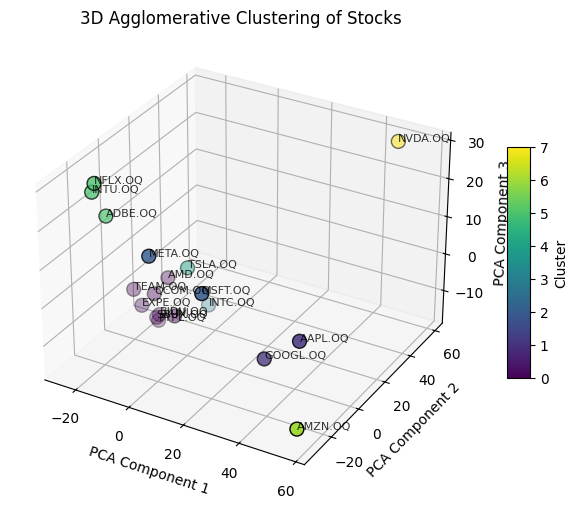

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(pca_arr[:, 0], pca_arr[:, 1], pca_arr[:, 2], 
                c=cluster_labels, cmap="viridis", s=100, edgecolor="black")

for i, stock in enumerate(universe_creation()):
    ax.text(pca_arr[i, 0], pca_arr[i, 1], pca_arr[i, 2], stock, fontsize=8, alpha=0.8)

ax.set_title("3D Agglomerative Clustering of Stocks")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")

cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Cluster")

plt.show()

#### Co-Integration Selection + Volatility Weighted Portofolio Creation  

In [ ]:
import importlib
import utils

importlib.reload(utils.methods)

<module 'utils.methods' from 'c:\\Users\\Alik\\Desktop\\M_year\\MPhil\\Options\\Quant&Finance\\QRT_Acad\\ML_PT\\Research\\utils\\methods.py'>

In [ ]:
from utils.methods import SelectCointegratedPairs

print('Manual-Stock-Universe: ', ', '.join(universe_creation()))

Manual-Stock-Universe:  AAPL.OQ, MSFT.OQ, GOOGL.OQ, AMZN.OQ, META.OQ, TSLA.OQ, NVDA.OQ, JNJ, AMD.OQ, INTC.OQ, QCOM.OQ, ADBE.OQ, NFLX.OQ, PYPL.OQ, SBUX.OQ, INTU.OQ, TEAM.OQ, BIDU.OQ, EXPE.OQ


In [ ]:
pairs = SelectCointegratedPairs(symbols=universe_creation(), cluster_labels=cluster_labels, history=df_uni10)

print(pairs)

 ---- Clusters ---- 

{1: ['AAPL.OQ', 'GOOGL.OQ'], 2: ['MSFT.OQ', 'META.OQ'], 6: ['AMZN.OQ'], 4: ['TSLA.OQ'], 7: ['NVDA.OQ'], 0: ['JNJ', 'AMD.OQ', 'QCOM.OQ', 'PYPL.OQ', 'SBUX.OQ', 'TEAM.OQ', 'BIDU.OQ', 'EXPE.OQ'], 3: ['INTC.OQ'], 5: ['ADBE.OQ', 'NFLX.OQ', 'INTU.OQ']}

 ------------- 
Testing cointegration in cluster 1 with 2 symbols.
AAPL.OQ GOOGL.OQ
p-Value:  0.8050446030721563
Testing cointegration in cluster 2 with 2 symbols.
MSFT.OQ META.OQ
p-Value:  0.21443302802244818
Testing cointegration in cluster 0 with 8 symbols.
JNJ AMD.OQ
p-Value:  0.6806095962635661
JNJ QCOM.OQ
p-Value:  0.8295446341711352
JNJ PYPL.OQ
p-Value:  0.776014979437593
JNJ SBUX.OQ
p-Value:  0.57635378534918
JNJ TEAM.OQ
p-Value:  0.7136374599457352
JNJ BIDU.OQ
p-Value:  0.772555978353236
JNJ EXPE.OQ
p-Value:  0.783386688430149
AMD.OQ QCOM.OQ
p-Value:  0.720182869462218
AMD.OQ PYPL.OQ
p-Value:  0.12482794167709949
AMD.OQ SBUX.OQ
p-Value:  0.6276247797185435
AMD.OQ TEAM.OQ
p-Value:  0.5696729395512607
AMD.OQ BIDU.O

My first goal should be to complete the basic pipeline before tuning the actual algorithm. This includes an end-to-end implementation, from stock selection to sending hedged portfolios to the QRT FTP servers for the daily report.

### Data Presence Matrix OR Stock Presence Matrix (in Universe)